# Trabalho 1 de MC886 --- UNICAMP 2019
Gabriel Costa ra172269

Giovanni Bertão ra173325

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import datetime
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import sklearn.linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

## Transforming the data

In [2]:
def transform(data):
    #Creating 2 features with date_time
    weekday = data['date_time'].values
    hour = weekday.copy()
    
    for i in range(len(weekday)):
        #Data time to day of the week
        weekday[i] = datetime.datetime.strptime(weekday[i], '%Y-%m-%d %H:%M:%S').weekday()
        #Date time to hour
        hour[i] = datetime.datetime.strptime(hour[i], '%Y-%m-%d %H:%M:%S').time().hour
    
    #Adding to the data frame
    data['weekday'] = weekday
    data['hour'] = hour
    data = data.drop(columns = 'date_time')
    data.head()
    
    #One hot encoding holiday and weather_description
    le_holiday = LabelEncoder()
    le_wd = LabelEncoder()
    data['holiday_encoded'] = le_holiday.fit_transform(data.holiday)
    data['weather_desc_encoded'] = le_wd.fit_transform(data.weather_description)
    holiday_ohe = OneHotEncoder()
    weather_desc_ohe = OneHotEncoder()
    X = holiday_ohe.fit_transform(data.holiday_encoded.values.reshape(-1,1)).toarray()
    dfOneHot = pd.DataFrame(X, columns = ["holiday_"+str(int(i)) for i in range(X.shape[1])])
    data = pd.concat([data, dfOneHot], axis=1)
    X = weather_desc_ohe.fit_transform(data.weather_desc_encoded.values.reshape(-1,1)).toarray()
    dfOneHot = pd.DataFrame(X, columns = ["weather_desc_"+str(int(i)) for i in range(X.shape[1])])
    data = pd.concat([data, dfOneHot], axis=1)
    
    #Removing string columns and label encoded columns
    data = data.drop(columns = ['holiday', 'weather_main', 'weather_description', 'holiday_encoded', 'weather_desc_encoded'])
    
    return data

## Spliting the Data

#### We shuffled the original data and splitted into new CSV files: 80% training, 10% validation and 10% test
#### The code below was executed only once

    data = pd.read_csv("./dataset/Metro_Interstate_Traffic_Volume.csv")

    data = transform(data)

    data = data.sample(frac=1)

    train_ratio = .80
    validation_ratio = .1
    test_ratio = 1 - (train_ratio + validation_ratio)

    train_total = int(len(data)*train_ratio)
    validation_total = int((len(data)*validation_ratio))

    data_train = data[:train_total]
    data_validation = data[train_total:train_total + validation_total]
    data_test = data[train_total + validation_total:]

    data_train.to_csv("./dataset/Train_Data.csv")
    data_validation.to_csv("./dataset/Validation_Data.csv")
    data_test.to_csv("./dataset/Test_Data.csv")

In [3]:
data = pd.read_csv("./dataset/Metro_Interstate_Traffic_Volume.csv")

## Importing Data

In [4]:
data_train = pd.read_csv("./dataset/Train_Data.csv")
data_validation = pd.read_csv("./dataset/Validation_Data.csv")

## Normalizing data

### Mean Normalization

In [5]:
def mean_normalize(data, validation =False, mean=None, maximum=None, minimum=None):
    if not validation:
        mean = data.mean()
        maximum = data.max()
        minimum = data.min()
        
    d_normalized = (data - mean)/(maximum - minimum)
    
    return (d_normalized, mean, maximum, minimum)

In [6]:
def undo_normalize(data, mean=None, maximum=None, minimum=None):
        
    d_normalized = (data*(maximum[0] - minimum[0])) + mean[0]
    
    return d_normalized

## Performing the Linear Regression

### Our Implementation

#### Hypothesis

In [7]:
def hypothesis_func(x, theta):
    return x.dot(theta)

#### Cost Function

In [8]:
def cost_func(x, theta, y):
    m = len(x)
    result = hypothesis_func(x, theta) - y
    result = result ** 2
    result = sum(result)/(2*m)
    
    return result

#### Gradient Function

In [9]:
def gradient_func(x, theta, y):
    m = len(x)
    result = hypothesis_func(x, theta) - y
    result = result * x
    result = sum(result)/m
    
    return result.reshape(theta.shape)

#### Error Function

In [10]:
def absolute_error(x, y):
    return np.median(abs((undo_normalize(y, Y_avg, Y_max, Y_min) - undo_normalize(x, Y_avg, Y_max, Y_min))))

#### Training Data

In [172]:
X_train = data_train.loc[:, data_train.columns != ('traffic_volume', 'temp', 'weekday', 'hour')]
X_train_norm, X_avg, X_max, X_min = mean_normalize(X_train)

In [173]:
Y_train = data_train.loc[:, data_train.columns == 'traffic_volume']
Y_train_norm, Y_avg, Y_max, Y_min = mean_normalize(Y_train)

#### Validation Data

In [174]:
X_val = data_validation.loc[:, data_validation.columns != ('traffic_volume', 'temp', 'weekday', 'hour')]
X_val_norm = mean_normalize(X_val, True, X_avg, X_max, X_min)[0]

In [175]:
Y_val = data_validation.loc[:, data_validation.columns == 'traffic_volume']
Y_val_norm = mean_normalize(Y_val, True, Y_avg, Y_max, Y_min)[0]

#### Gradient Descent Process --- Vanilla

In [112]:
# Preparing the X, Y and Theta vectors
# Train
num_rows, num_cols = X_train_norm.shape
x_train = np.ones((num_rows, num_cols + 1))
x_train[:,1:] = X_train_norm

y_train = Y_train_norm.values

# Validation
num_rows, num_cols = X_val_norm.shape
x_val = np.ones((num_rows, num_cols + 1))
x_val[:,1:] = X_val_norm

y_val = Y_val_norm.values

# Generating a initial theta
np.random.seed(42)
theta = np.random.randint(1000, size=((num_cols + 1, 1)))

# Executing the algorithm
num_itera = 1000
learning_rate = 0.1
train_error = [cost_func(x_train, theta, y_train)]
valid_error = [cost_func(x_val, theta, y_val)]
start_time = time.time()
for itr in range(num_itera):
    if (itr % (num_itera/10) == 0):
        print("{}%".format(itr*100/num_itera))
    theta = theta - learning_rate * gradient_func(x_train, theta, y_train)
    train_error.append(cost_func(x_train, theta, y_train))
    valid_error.append(cost_func(x_val, theta, y_val))
total_time = time.time() - start_time
theta_vanilla = theta
print("Trainned in {} seconds".format(total_time))

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
Trainned in 105.09626960754395 seconds


##### Cost Function vs iterations plot

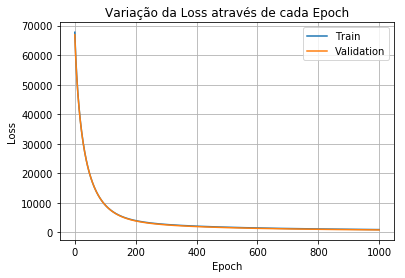

In [113]:
plt.plot(train_error, label = "Train")
plt.plot(valid_error, label = "Validation")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid()
plt.title("Variação da Loss através de cada Epoch")
plt.legend()
plt.savefig("ex2.eps")

##### Absolute Error

In [114]:
error1 = np.abs(x_val.dot(theta) - y_val)
print("MIN:{:.2f} MAX:{:.2f}".format(min(error1)[0],max(error1)[0]))

MIN:0.00 MAX:441.27


In [115]:
error2 = np.abs(x_val.dot(theta) - y_val)
print("MIN:{:.2f} MAX:{:.2f}".format(min(error2)[0],max(error2)[0]))

MIN:0.00 MAX:441.27


In [116]:
error3 = np.abs(x_val.dot(theta) - y_val)
print("MIN:{:.2f} MAX:{:.2f}".format(min(error3)[0],max(error3)[0]))

MIN:0.00 MAX:441.27


#### Gradient Descent Process --- Mini Batch

In [132]:
# Fixing the X and Y vectors for Mini Batch
#Train
num_rows, num_cols = X_train_norm.shape
X_train = np.ones((num_rows, num_cols + 1))
X_train[:,1:] = X_train_norm

y_train = Y_train_norm['traffic_volume'].values

# Validation
num_rows, num_cols = X_val_norm.shape
X_valid = np.ones((num_rows, num_cols + 1))
X_valid[:,1:] = X_val_norm

y_valid = Y_val_norm['traffic_volume'].values

#Initial theta
theta = np.random.randint(1000, size=(1, len(X_train[0])))
theta = theta[0]

#Epoch = run through all training data
#Batch size = number of training examples in one batch
#Iteration = Number of batches needed to complete one Epoch
m = len(y_train)
epochs = 1000
batch_size = 50
iterations = m//batch_size
learning_rate = 0.1

train_error = []
valid_error = []

train_result_error = []
valid_result_error = []

#Mini-batch GD
start_time = time.time()
for i in range(epochs):
    if (i % (epochs/10) == 0):
        print("{}%".format(i*100/epochs))
    for j in range(iterations-1):
        #Updating theta
        x_train_batch = X_train[j*batch_size:(j+1)*batch_size]
        y_train_batch = y_train[j*batch_size:(j+1)*batch_size]
        theta = theta - (learning_rate/batch_size) * x_train_batch.T.dot(x_train_batch.dot(theta) - y_train_batch)
    #Undoing normalization
    y = undo_normalize(y_train, Y_avg, Y_max, Y_min)
    x = undo_normalize(X_train.dot(theta), Y_avg, Y_max, Y_min)
    #Getting result mean error for each epoch
    train_result_error.append(abs(np.mean(x - y)))
    #Getting train cost function error for each epoch
    train_error.append(cost_func(X_train, theta, y_train))
    #Undoing normalization
    y = undo_normalize(y_valid, Y_avg, Y_max, Y_min)
    x = undo_normalize(X_valid.dot(theta), Y_avg, Y_max, Y_min)
    #Getting result mean error for each epoch
    valid_result_error.append(abs(np.mean(x - y)))
    #Getting validation cost function error for each epoch
    valid_error.append(cost_func(X_valid, theta, y_valid))
print("Trained in {} seconds".format(time.time() - start_time))
theta_mb = theta.reshape((theta.shape[0],1))

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
Trained in 29.457943439483643 seconds


##### Cost Function vs iterations plot

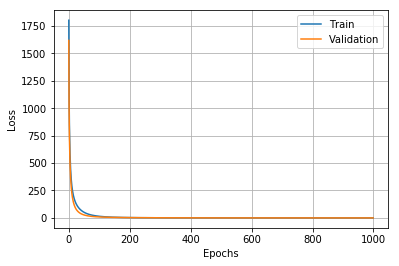

In [133]:
plt.plot(train_error, label = "Train")
plt.plot(valid_error, label = "Validation")
plt.ylabel("Loss")
plt.grid()
plt.xlabel("Epochs")
plt.legend()
plt.savefig("mb.eps")

##### Absolute Error

In [134]:
error = np.abs(X_valid.dot(theta) - y_valid)
print("MIN:{:.2f} MAX:{:.2f}".format(min(error),max(error)))

MIN:0.00 MAX:4.01


#### Predicted vs Actual Error (Starting on Epoch 10)

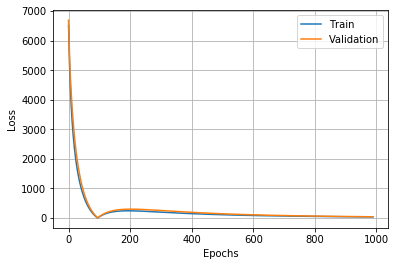

In [135]:
plt.plot(train_result_error[10:], label = "Train")
plt.plot(valid_result_error[10:], label = "Validation")
plt.ylabel("Loss")
plt.grid()
plt.xlabel("Epochs")
plt.legend()
plt.savefig("result1.eps")

#### Predicted vs Actual Error (Last 10 Epochs)

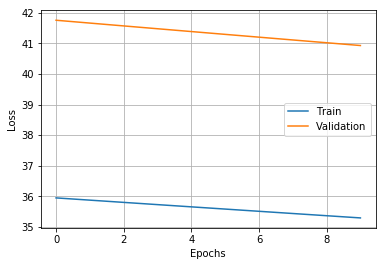

In [136]:
plt.plot(train_result_error[990:], label = "Train")
plt.plot(valid_result_error[990:], label = "Validation")
plt.ylabel("Loss")
plt.grid()
plt.xlabel("Epochs")
plt.legend()
plt.savefig("result2.eps")

### Using Sklearn

In [141]:
# Preparing the X, Y and Theta vectors
# Train
num_rows, num_cols = X_train_norm.shape
x_train = np.ones((num_rows, num_cols + 1))
x_train[:,1:] = X_train_norm

y_train = Y_train_norm.values

# Validation
num_rows, num_cols = X_val_norm.shape
x_val = np.ones((num_rows, num_cols + 1))
x_val[:,1:] = X_val_norm

y_val = Y_val_norm.values

clf = sklearn.linear_model.SGDRegressor(learning_rate="constant", eta0=0.1, max_iter=1000, tol=1e-3)
clf.fit(x_train, y_train.reshape(y_train.shape[0]))
y_pred = clf.predict(x_val)

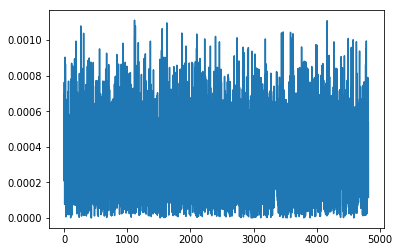

In [142]:
plt.plot(np.abs(y_pred.reshape(y_pred.shape[0],1) - y_val))
plt.savefig("sgd.eps")

In [143]:
error = np.abs(y_pred.reshape(y_pred.shape[0],1) - y_val)
print("MIN:{:.4f} MAX:{:.4f}".format(min(error)[0],max(error)[0]))

MIN:0.0000 MAX:0.0011


### Using Normal Equation

In [176]:
def normal_equation(x,y):
    return np.linalg.inv(x.T.dot(x)).dot(x.T.dot(y))

In [177]:
# Preparing the X, Y and Theta vectors
# Train
num_rows, num_cols = X_train_norm.shape
x_train = np.ones((num_rows, num_cols + 1))
x_train[:,1:] = X_train_norm

y_train = Y_train_norm.values

# Validation
num_rows, num_cols = X_val_norm.shape
x_val = np.ones((num_rows, num_cols + 1))
x_val[:,1:] = X_val_norm

y_val = Y_val_norm.values

theta = normal_equation(x_train, y_train)
theta_normal = theta

#### Absolute Error

In [178]:
error = np.abs(x_val.dot(theta) - y_val)
print("MIN:{:.4f} MAX:{:.4f}".format(min(error)[0],max(error)[0]))

MIN:0.0000 MAX:0.0229


## Using on Test

In [151]:
data_test = pd.read_csv("./dataset/Test_Data.csv")

In [152]:
X_test = data_test.loc[:, data_validation.columns != ('traffic_volume', 'temp', 'weekday', 'hour')]
X_test_norm = mean_normalize(X_test, True, X_avg, X_max, X_min)[0]

In [153]:
Y_test = data_test.loc[:, data_validation.columns == 'traffic_volume']
Y_test_norm = mean_normalize(Y_test, True, Y_avg, Y_max, Y_min)[0]

In [154]:
num_rows, num_cols = X_test_norm.shape
x_test = np.ones((num_rows, num_cols + 1))
x_test[:,1:] = X_test_norm

y_test = Y_test_norm.values

### Vanilla

In [155]:
error_van = np.abs(x_test.dot(theta_vanilla) - y_test)
print("MIN:{:.2f} MAX:{:.2f}".format(min(error_van)[0],max(error_van)[0]))

MIN:0.00 MAX:483.10


### Sklearn

In [156]:
y_pred = clf.predict(x_test)
error_sk = np.abs(y_pred.reshape(y_pred.shape[0],1) - y_test)
print("MIN:{:.4f} MAX:{:.4f}".format(min(error_sk)[0],max(error_sk)[0]))

MIN:0.0000 MAX:0.0013


### Mini-Batch

In [157]:
error_mb = np.abs(x_test.dot(theta_mb) - y_test)
print("MIN:{:.4f} MAX:{:.4f}".format(min(error_mb)[0],max(error_mb)[0]))

MIN:0.0000 MAX:1.4657


### Normal Function

In [158]:
error_nf = np.abs(x_test.dot(theta_normal) - y_test)
print("MIN:{:.4f} MAX:{:.4f}".format(min(error_nf)[0],max(error_nf)[0]))

MIN:0.0000 MAX:0.0184
